In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import tqdm

import autobl.steering
from autobl.steering.configs import *
from autobl.steering.measurement import *
from autobl.steering.acquisition import *
from autobl.util import *

torch.set_default_device('cpu')

In [3]:
data_path = 'data/raw/LiTiO_XANES/dataanalysis/Originplots/Sample1_50C_XANES.csv'

In [4]:
data_all_spectra = pd.read_csv(data_path, header=None)
data_all_spectra

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,4936.000000,4936.500000,4937.000000,4937.500000,4938.000000,4938.500000,4939.000000,4939.500000,4940.000000,4940.50000,...,5001.50000,5002.00000,5002.50000,5003.00000,5003.50000,5004.00000,5004.50000,5005.00000,5005.50000,5006.00000
1,0.005420,-0.000265,0.001830,0.003960,0.000507,0.002170,0.004290,0.001660,0.008580,0.00457,...,1.34627,1.33542,1.32561,1.30748,1.27745,1.25692,1.22866,1.19840,1.16776,1.13832
2,0.000399,0.001930,0.003800,0.001530,0.001090,0.003250,0.000448,0.000324,0.006140,0.00445,...,1.33703,1.32843,1.31673,1.30007,1.27325,1.24884,1.21725,1.19444,1.16368,1.13456
3,0.004960,0.007110,0.001490,0.000174,0.000674,0.002970,0.004700,0.001770,0.003300,0.00433,...,1.33959,1.32791,1.31768,1.29564,1.27382,1.25032,1.22341,1.19401,1.16089,1.13613
4,0.003510,0.002480,0.000983,0.000178,0.000705,0.002130,0.005450,-0.000759,0.001930,0.00311,...,1.33333,1.32914,1.31438,1.29633,1.27064,1.24557,1.22360,1.19474,1.16229,1.13286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.003510,0.002610,0.000659,-0.002530,-0.002550,0.003750,0.004680,-0.004530,0.000895,0.00416,...,1.22189,1.24877,1.25049,1.24624,1.23297,1.21781,1.20075,1.18945,1.17262,1.15319
125,-0.000972,-0.003700,-0.001510,-0.008560,-0.005030,-0.000713,-0.000946,-0.004490,0.001080,-0.00203,...,1.22255,1.22380,1.23450,1.23352,1.22399,1.20301,1.19104,1.17716,1.16057,1.14369
126,0.003660,0.001200,-0.000220,0.003630,0.003010,0.003860,0.000327,-0.000153,0.006030,0.00173,...,1.22356,1.23407,1.24095,1.23811,1.22552,1.21022,1.19423,1.18404,1.16565,1.14718
127,0.000999,0.000135,0.000794,-0.000515,0.000775,0.002160,-0.000492,-0.000762,-0.000787,-0.00152,...,1.21150,1.21795,1.22707,1.22468,1.21487,1.20169,1.18085,1.16794,1.15274,1.13740


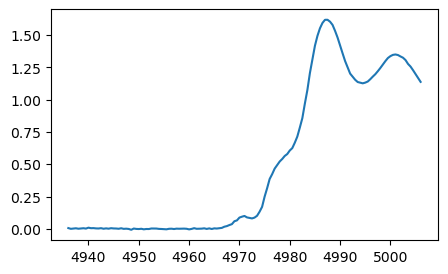

In [5]:
data = data_all_spectra.iloc[1].to_numpy()
energies = data_all_spectra.iloc[0].to_numpy()
energies = torch.tensor(energies)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), data)
plt.show()

Utility functions for analysis

In [6]:
def rms(actual, true):
    return np.sqrt(np.mean((actual - true) ** 2))

def create_intermediate_figure(n_target_measurements, n_plot_interval=20):
    n_plots = int(np.ceil(n_target_measurements / n_plot_interval))
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)
    return fig, ax

def update_intermediate_figure(guide, energies, data, n_measured, i_plot, axes):
    n_rows = len(axes)
    n_cols = len(axes[0])
    # guide.plot_posterior(energies)
    guide.plot_posterior(energies, ax=axes[i_plot // n_cols][i_plot % n_cols])
    axes[i_plot // n_cols][i_plot % n_cols].plot(to_numpy(energies), data, label='Truth', color='gray', alpha=0.6)
    axes[i_plot // n_cols][i_plot % n_cols].set_title('{} points'.format(n_measured))
    axes[i_plot // n_cols][i_plot % n_cols].legend()

def create_convergence_figure_and_data():
    fig, ax = plt.subplots(1, 1)
    return fig, ax, [], []

def update_convergence_data(guide, n_measured, n_measured_list, metric_list):
    mu, _ = guide.get_posterior_mean_and_std(energies[:, None])
    mu = mu.squeeze()
    metric = rms(mu.detach().cpu().numpy(), data)
    n_measured_list.append(n_measured)
    metric_list.append(metric)
    return n_measured_list, metric_list

def plot_convergence(fig, ax, n_measured_list, metric_list):
    ax.plot(n_measured_list, metric_list)
    ax.set_xlabel('Points measured')
    ax.set_ylabel('RMS')

def get_save_name_prefix(config, guide):
    data_name = os.path.splitext(os.path.basename(data_path))[0]
    
    acquisition_info = config.acquisition_function_class.__name__
    if config.acquisition_function_class == GradientAwarePosteriorStandardDeviation:
        acquisition_info += '_phi_{}'.format(guide.acquisition_function.phi)
        
    kernel_info = '{}_lengthscale_{:.3f}'.format(guide.model.covar_module.__class__.__name__, 
                                                 guide.unscale_by_normalizer_bounds(
                                                     guide.model.covar_module.lengthscale.item()
                                                 ))
    if isinstance(guide.model.covar_module, gpytorch.kernels.MaternKernel):
        kernel_info += '_nu_{}'.format(guide.model.covar_module.nu)

    save_name_prefix = '_'.join([data_name, acquisition_info, kernel_info])
    return save_name_prefix

Creating a common config template:

In [15]:
config = GPExperimentGuideConfig(
        dim_measurement_space=1,
        num_candidates=1,
        model_class=botorch.models.SingleTaskGP,
        model_params={'covar_module': gpytorch.kernels.MaternKernel(2.5)},
        override_kernel_lengthscale=7,
        lower_bounds=torch.tensor([energies[0]]),
        upper_bounds=torch.tensor([energies[-1]]),
        optimizer_params={'num_restarts': 2}
)

In [8]:
instrument = SimulatedMeasurement(data=(energies[None, :], data))

Sample 10 points with equal spacing to initialize.

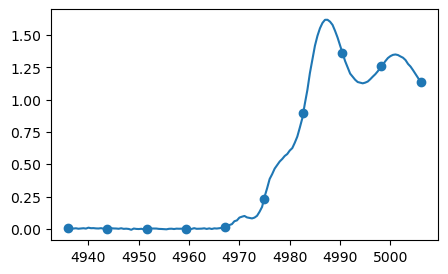

In [9]:
n_init = 10
x_init = torch.linspace(energies[0], energies[-1], n_init).double().reshape(-1, 1)
y_init = instrument.measure(x_init).reshape(-1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), to_numpy(data))
ax.scatter(to_numpy(x_init), to_numpy(y_init))
plt.show()

In [10]:
def run_simulated_experiment(config, x_init, y_init):
    guide = autobl.steering.guide.GPExperimentGuide(config)
    guide.build(x_init, y_init)
    
    n_target_measurements = len(data) - n_init
    n_plot_interval = 20
    n_measured = n_init
    
    fig_intermediate, axes_intermediate = create_intermediate_figure(n_target_measurements, n_plot_interval)
    fig_conv, axes_conv, n_measured_list, metric_list = create_convergence_figure_and_data()
    i_plot = 0
    for i in tqdm.trange(n_target_measurements):
        candidates = guide.suggest().double()
        y_new = instrument.measure(candidates).unsqueeze(-1)
        guide.update(candidates, y_new)
        n_measured += len(candidates)
        if i % n_plot_interval == 0:
            update_intermediate_figure(guide, energies, data, n_measured, i_plot, axes_intermediate)
            i_plot += 1
        update_convergence_data(guide, n_measured, n_measured_list, metric_list)
        
    plot_convergence(fig_conv, axes_conv, n_measured_list, metric_list)
    fig_intermediate.savefig(os.path.join('outputs', get_save_name_prefix(config, guide) + '_intermediate.pdf'))
    fig_conv.savefig(os.path.join('outputs', get_save_name_prefix(config, guide) + '_conv.pdf'))
    np.savetxt(os.path.join('outputs', get_save_name_prefix(config, guide) + '_conv.txt'), np.stack([n_measured_list, metric_list]))

# Experiments with different acquisition functions

## Posterior standard deviation

In [11]:
config.acquisition_function_class = PosteriorStandardDeviation
config.acquisition_function_params = {}

[2024-04-03 16:54:20,044] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-03 16:54:20,437] Kernel lengthscale after optimization (normalized & standardized): [[0.30632671]]
[2024-04-03 16:54:20,445] Kernel lengthscale (normalized & standardized) overriden to: 7
 93%|███████████████████████████████████████████████████████████████████     | 122/131 [00:18<00:02,  3.79it/s]/data/programs/autobl/autobl/steering/optimization.py:58: UserWarning: All suggested points have been measured in the past! (tensor([[[0.8465]],

        [[0.3469]],

        [[1.0000]],

        [[1.0000]],

        [[1.0000]]], dtype=torch.float64))
  warnings.warn('All suggested points have been measured in the past! ({})'.format(pts))
100%|████████████████████████████████████████████████████████████████████████| 131/131 [00:21<00:00,  6.22it/s]


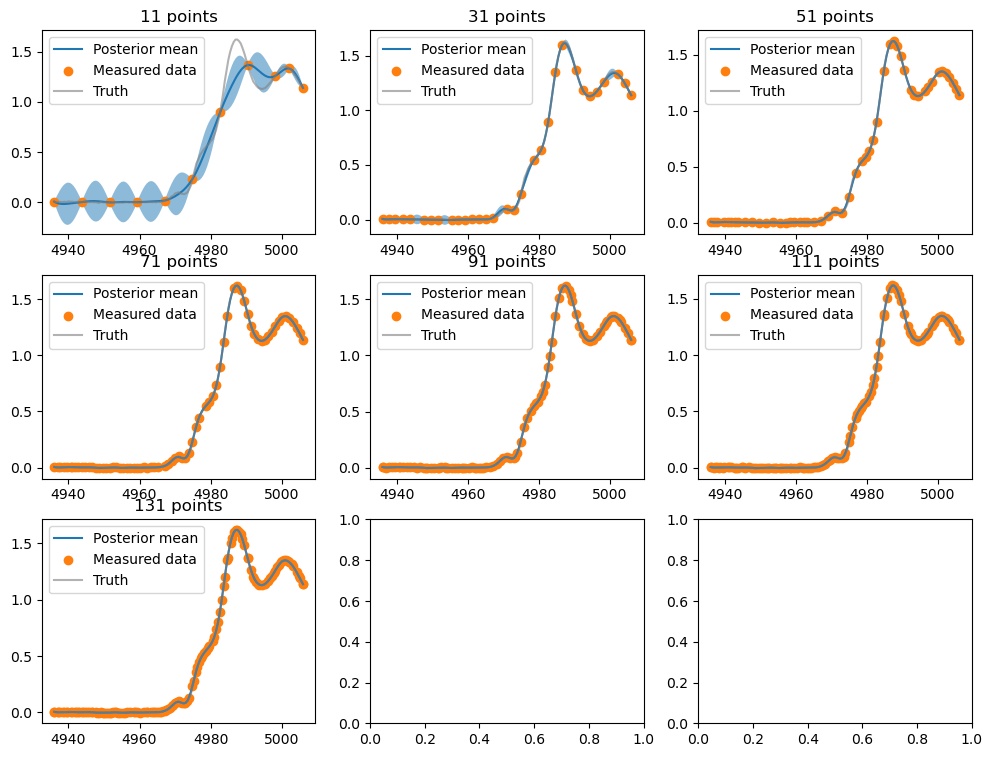

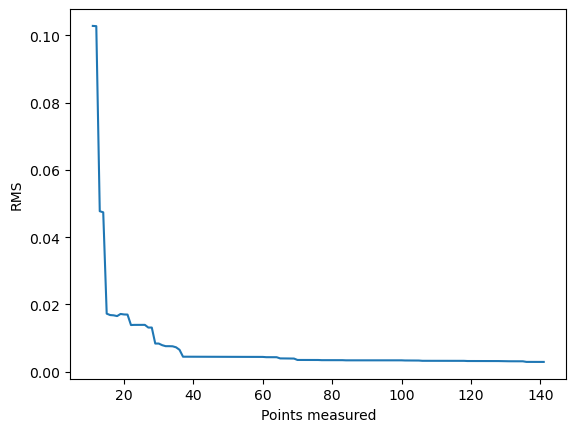

In [12]:
run_simulated_experiment(config, x_init, y_init)

## Gradient-aware posterior standard deviation

In [16]:
config.acquisition_function_class = GradientAwarePosteriorStandardDeviation
config.acquisition_function_params = {'phi': 1e-4}

[2024-04-03 16:57:08,343] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-03 16:57:08,607] Kernel lengthscale after optimization (normalized & standardized): [[0.30632671]]
[2024-04-03 16:57:08,609] Kernel lengthscale (normalized & standardized) overriden to: 7
  8%|█████▌                                                                   | 10/131 [00:02<00:28,  4.24it/s]/home/beams/MINGDU/anaconda3/envs/botorch_cuda/lib/python3.11/site-packages/botorch/optim/optimize.py:362: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 15%|██████████▌                                                              | 19/131 [00:06<00:42,  2.61it/s]/home/beams/MINGDU/anaconda3/envs/bot

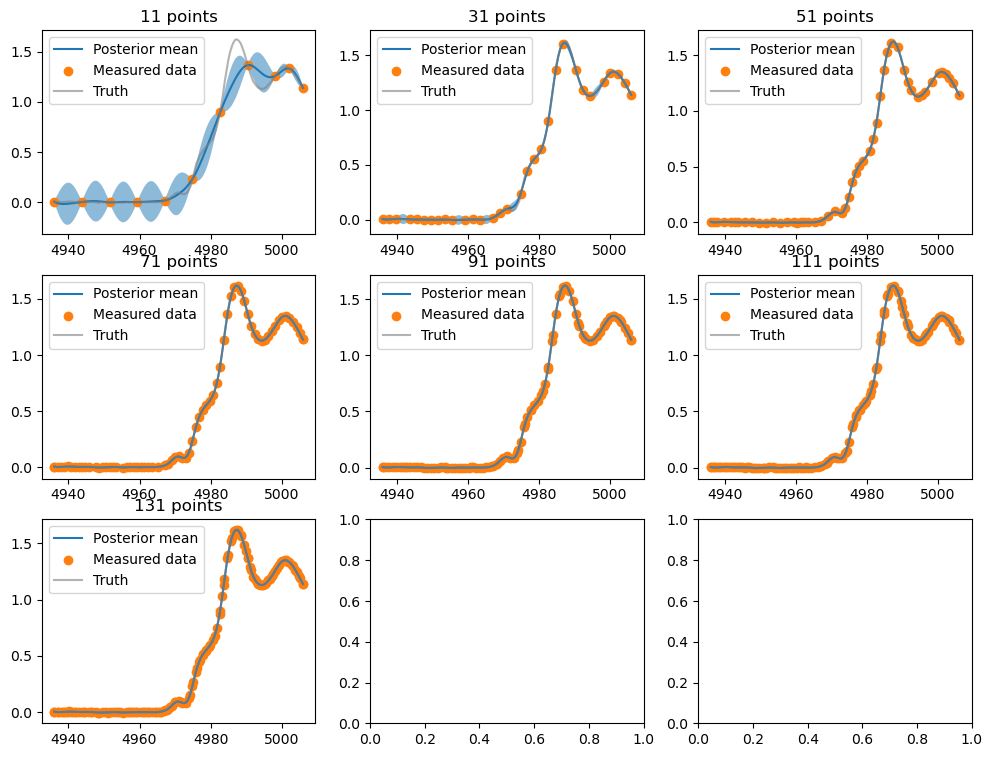

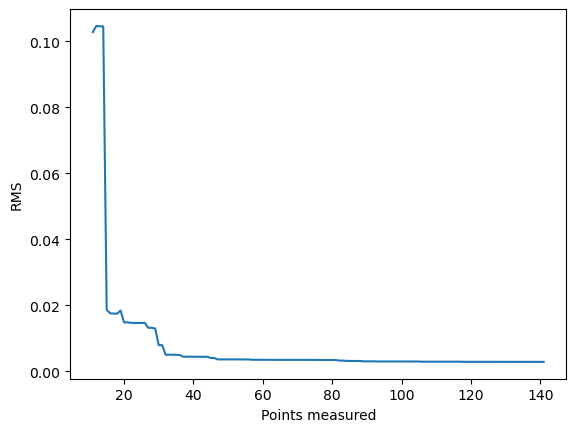

In [17]:
run_simulated_experiment(config, x_init, y_init)

 # Overall experiment with acquisition functions, acquisition parameters, and kernel parameters

[2024-04-03 15:40:34,798] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-03 15:40:34,998] Kernel lengthscale after optimization (normalized & standardized): [[0.30632671]]
[2024-04-03 15:40:35,000] Kernel lengthscale (normalized & standardized) overriden to: 3.5
100%|████████████████████████████████████████████████████████████████████████| 131/131 [00:14<00:00,  9.27it/s]
[2024-04-03 15:40:50,309] Kernel lengthscale before optimization (normalized & standardized): [[0.05]]
[2024-04-03 15:40:50,485] Kernel lengthscale after optimization (normalized & standardized): [[0.30632681]]
[2024-04-03 15:40:50,486] Kernel lengthscale (normalized & standardized) overriden to: 7.0
 69%|██████████████████████████████████████████████████▋                      | 91/131 [00:08<00:04,  8.80it/s]/data/programs/autobl/autobl/steering/optimization.py:58: UserWarning: All suggested points have been measured in the past! (tensor([[[0.0000]],

        [[0.6527]],



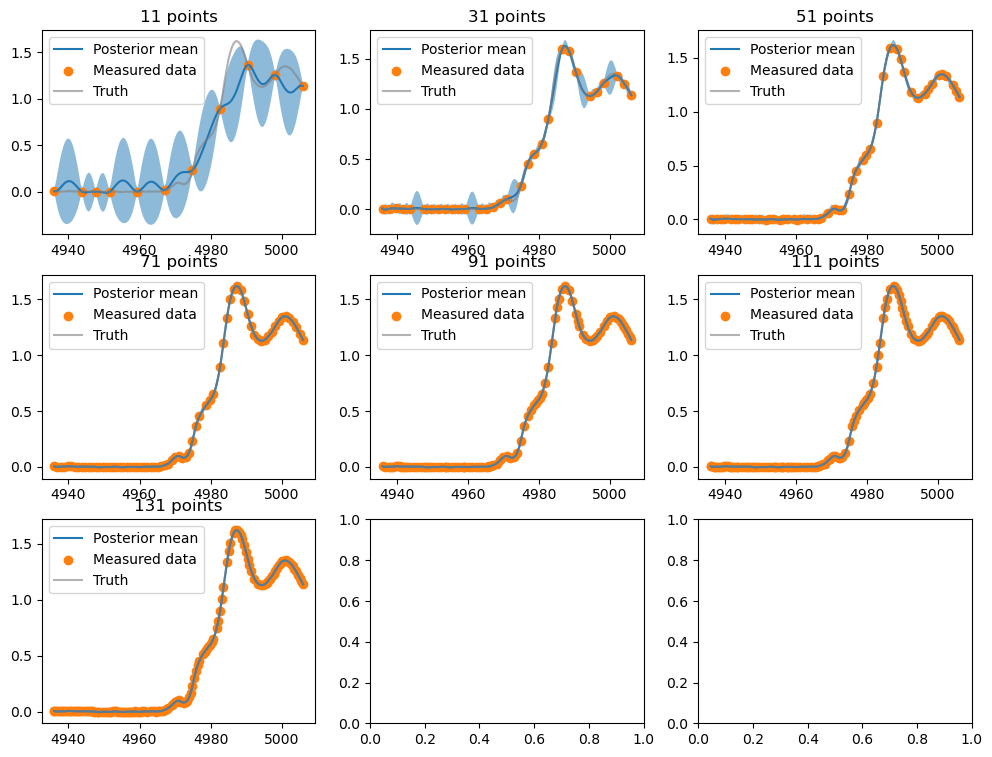

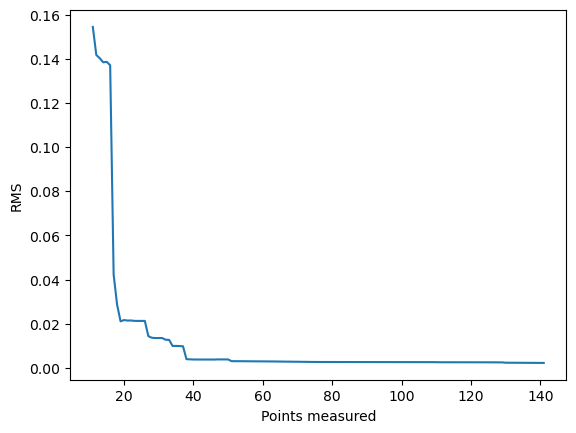

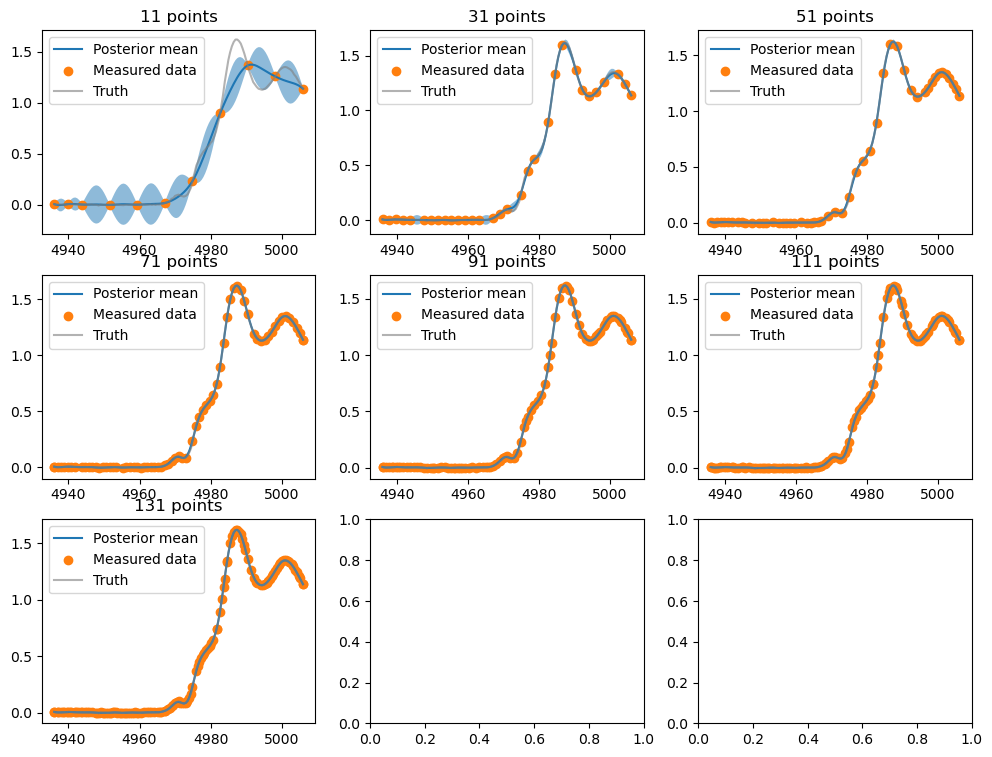

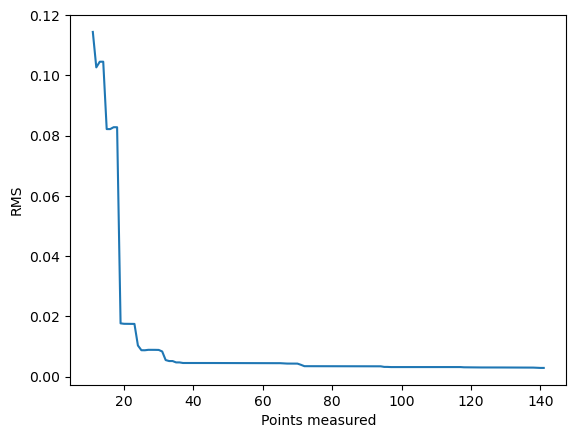

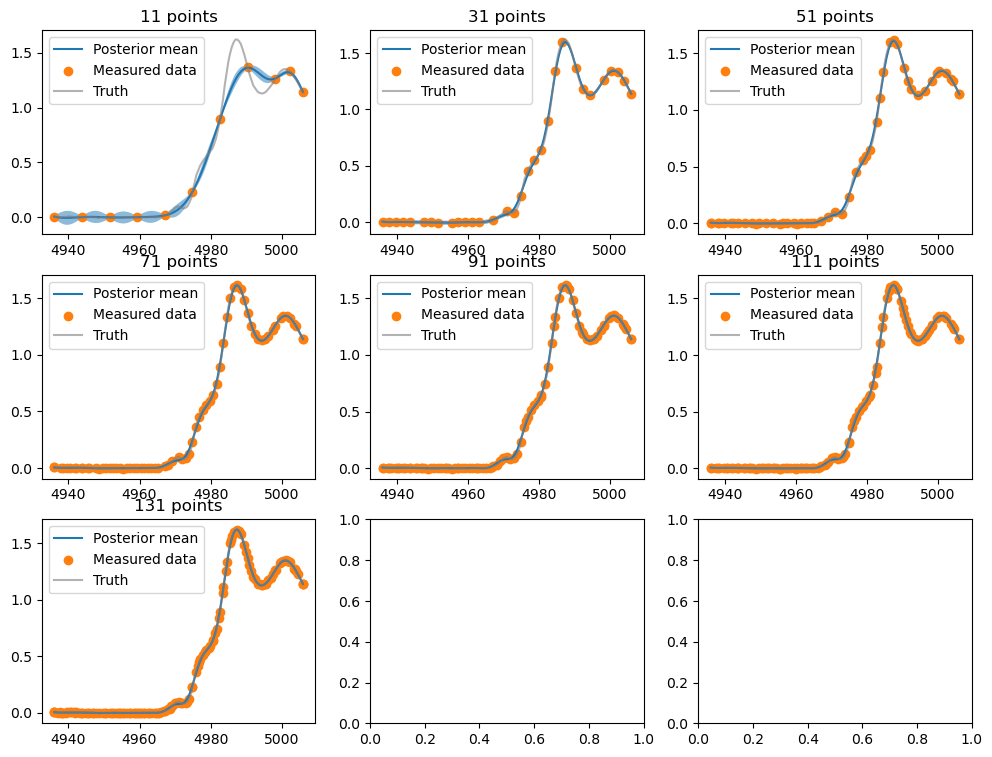

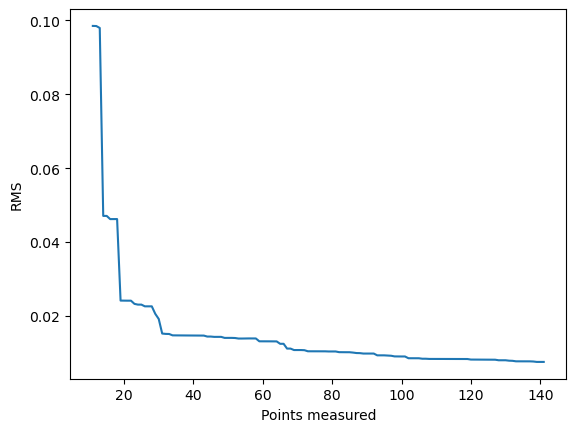

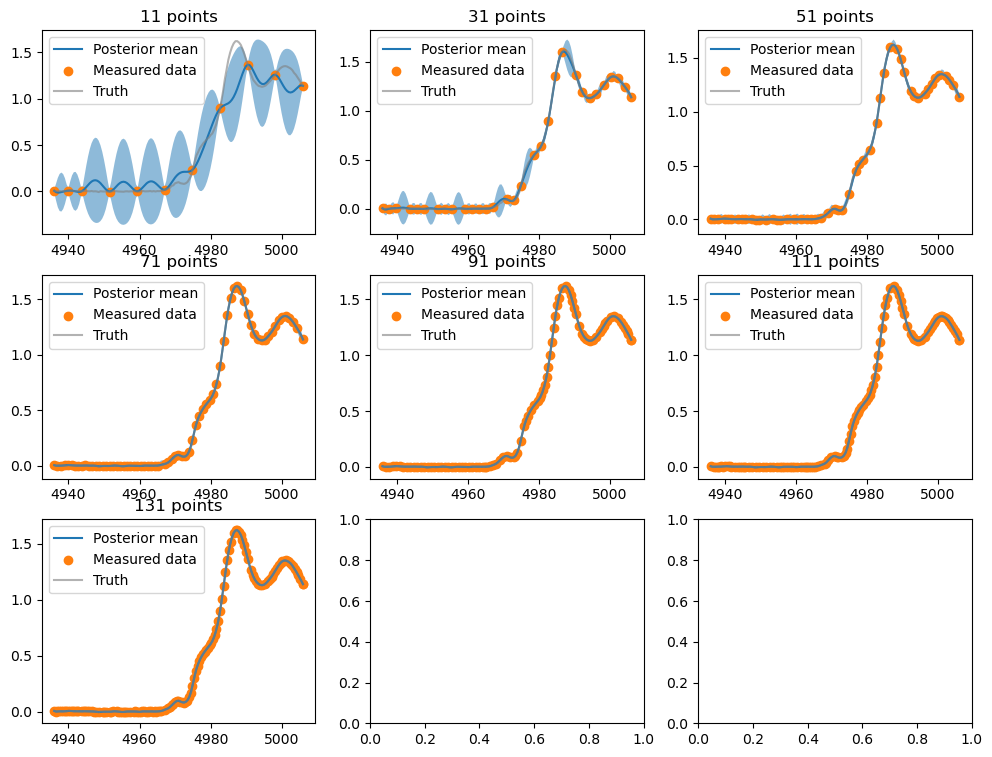

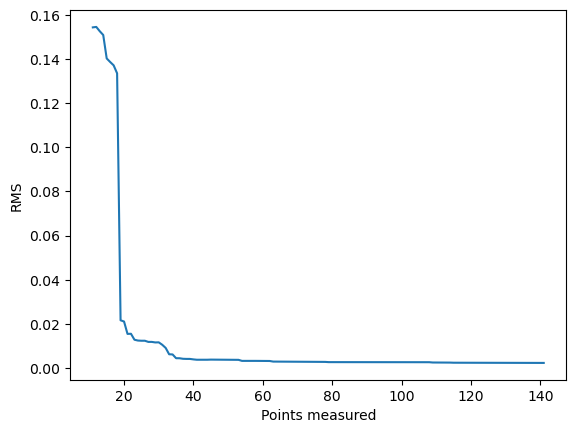

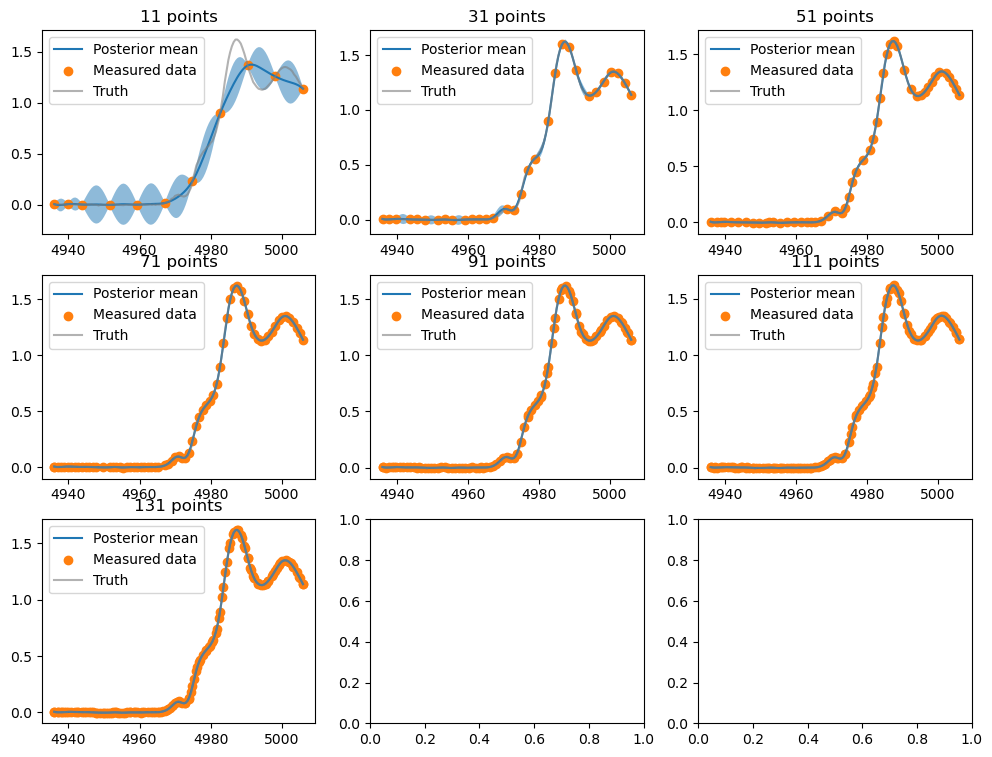

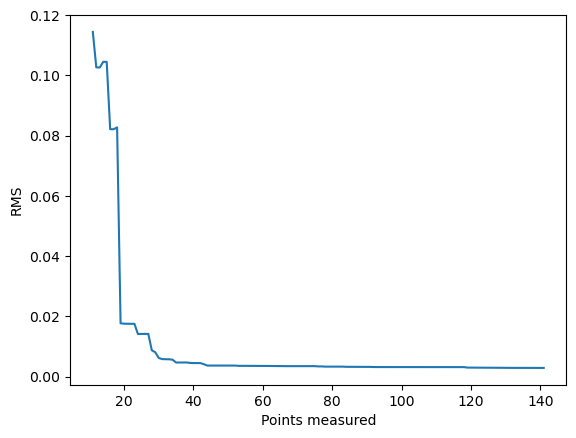

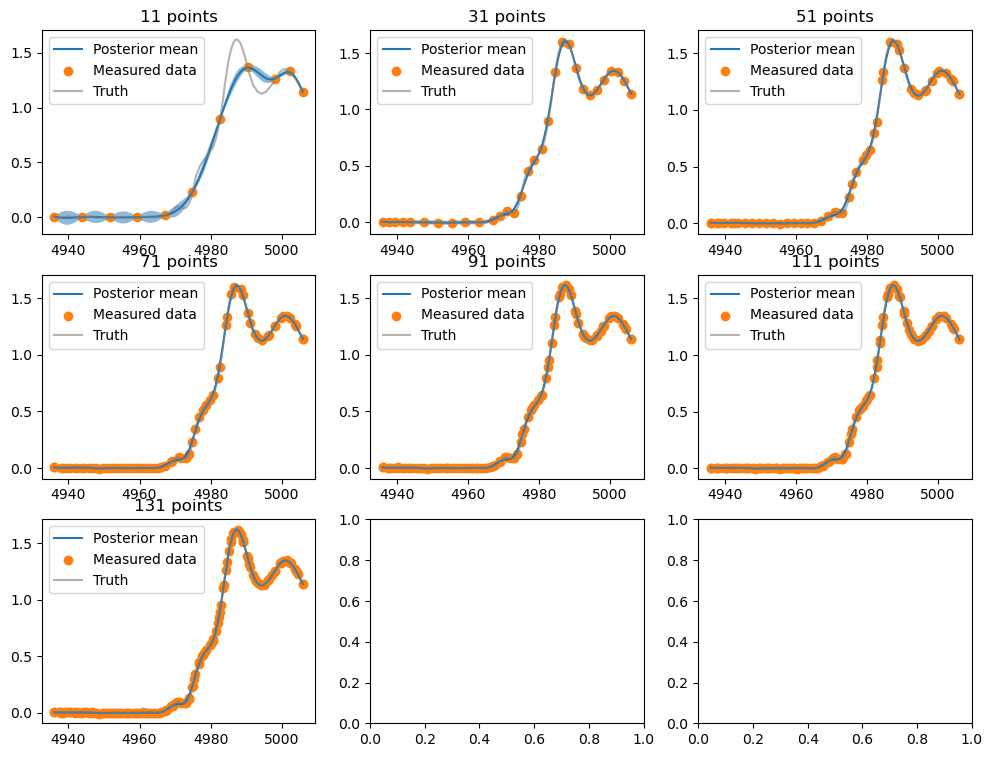

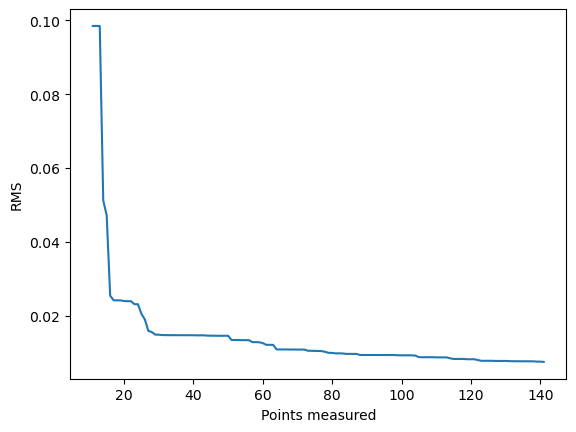

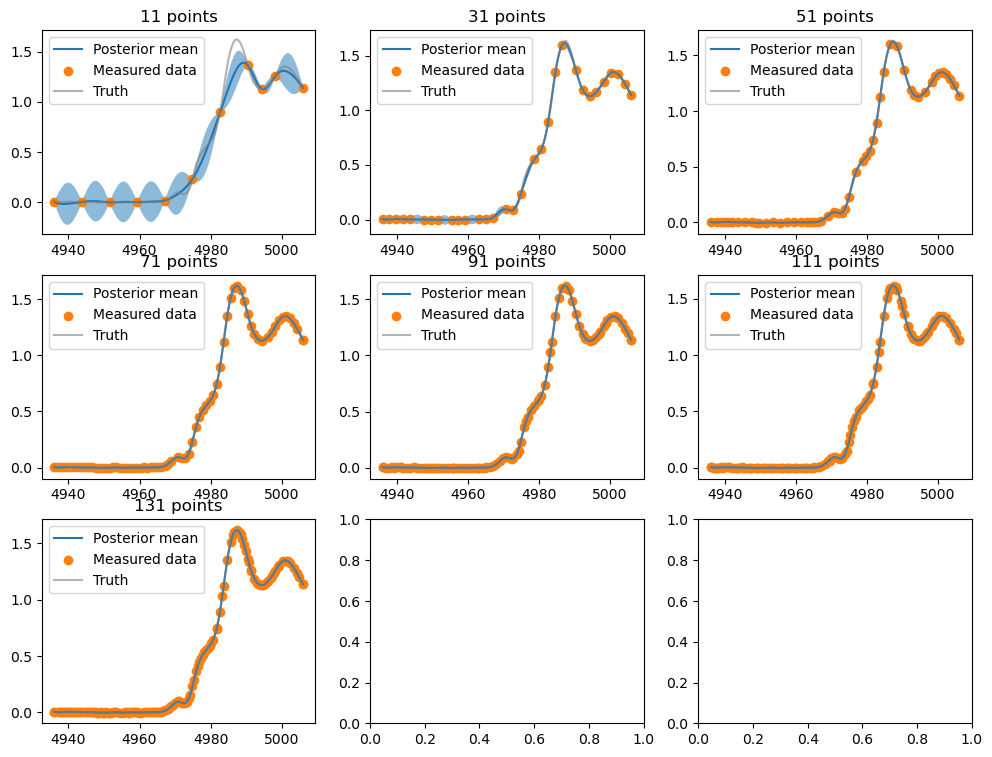

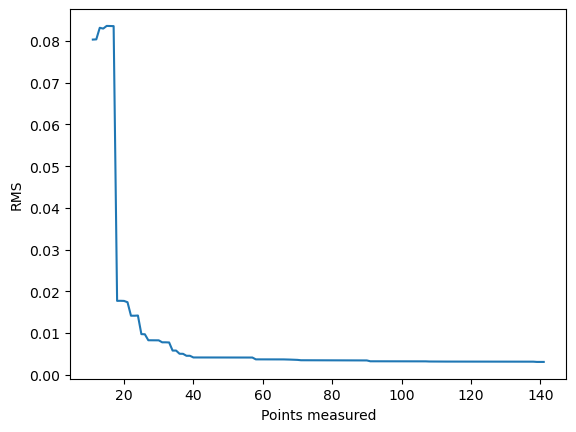

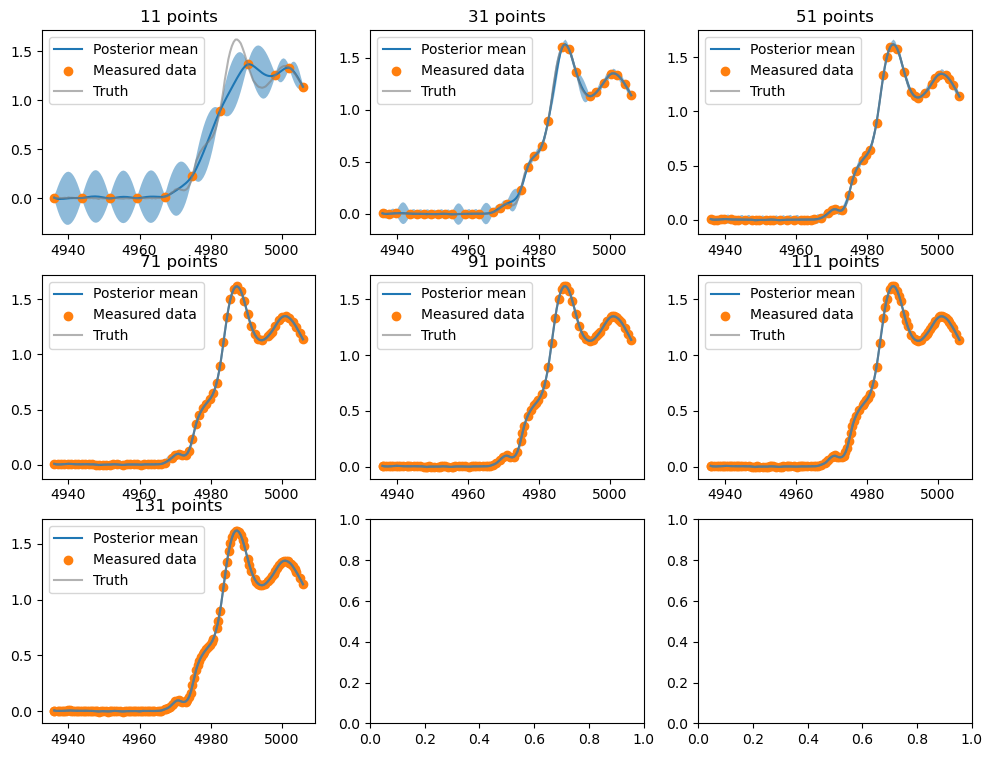

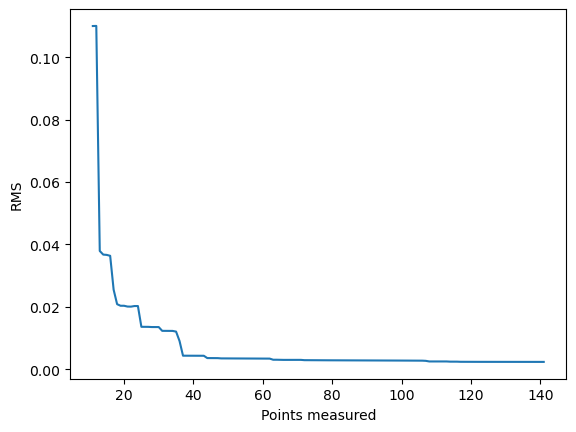

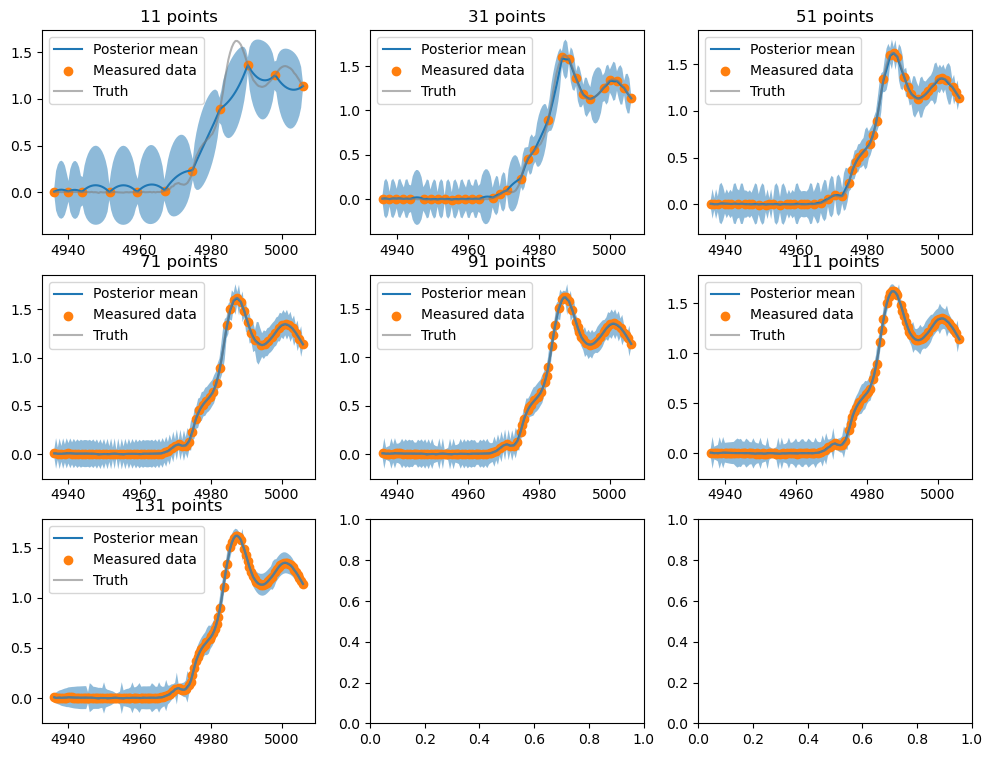

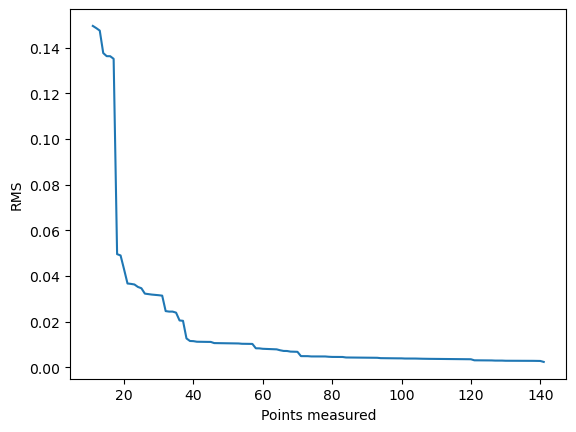

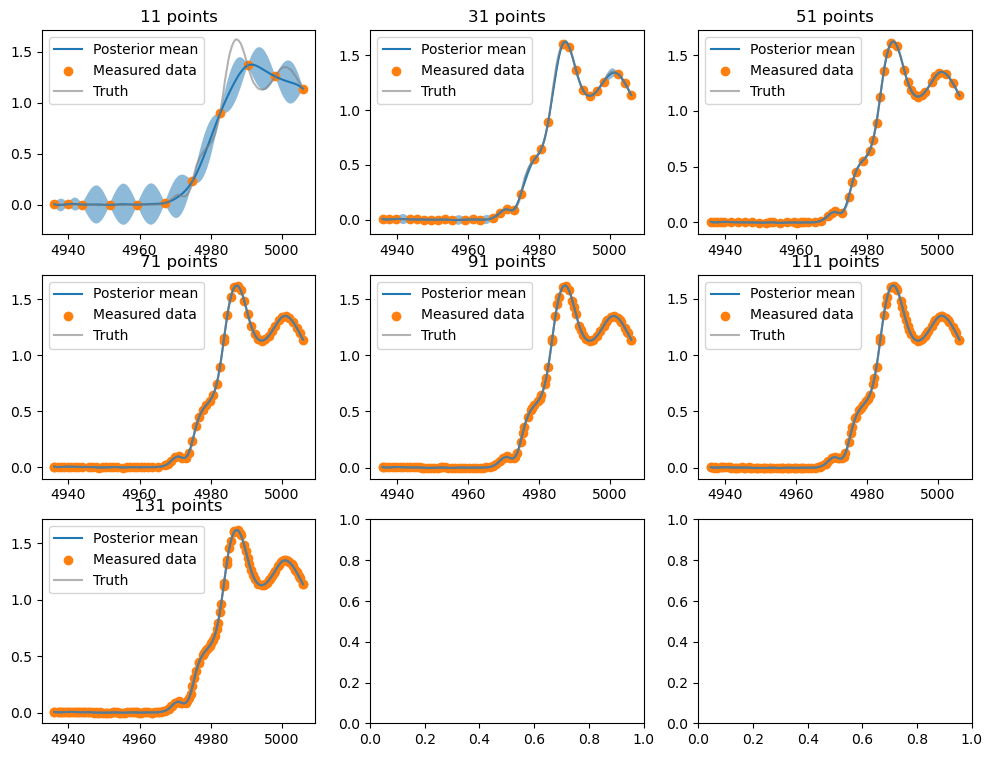

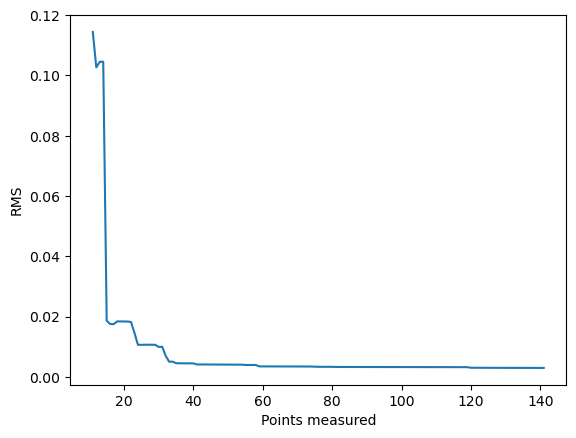

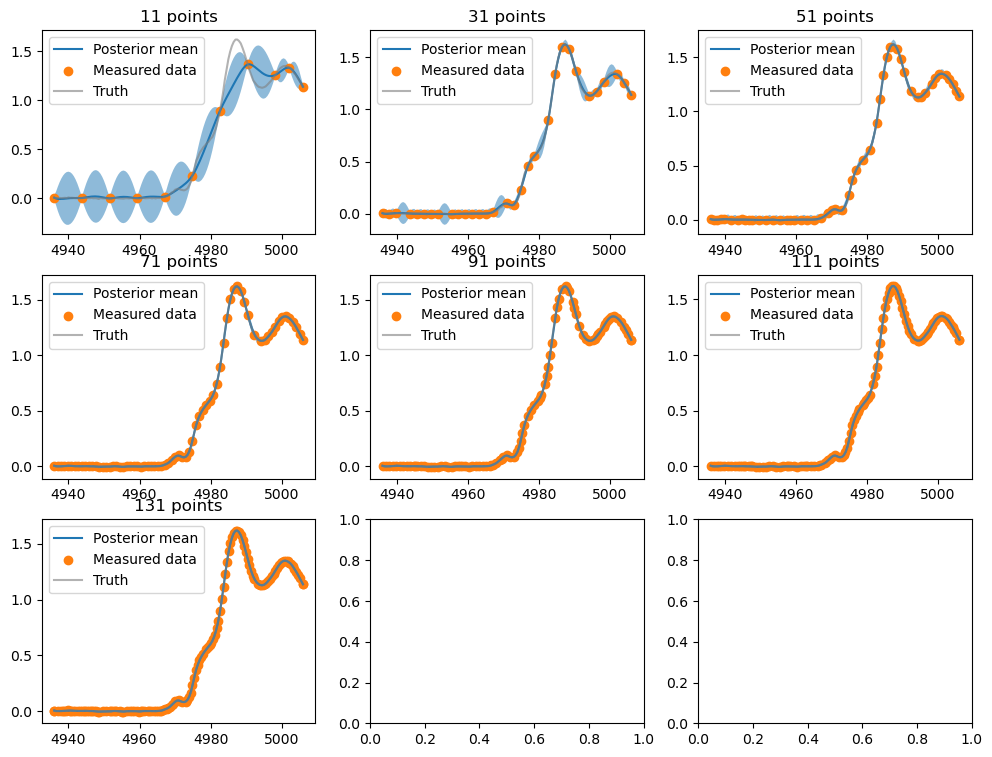

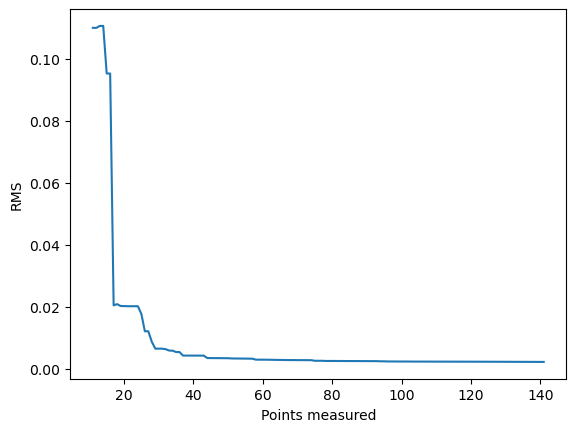

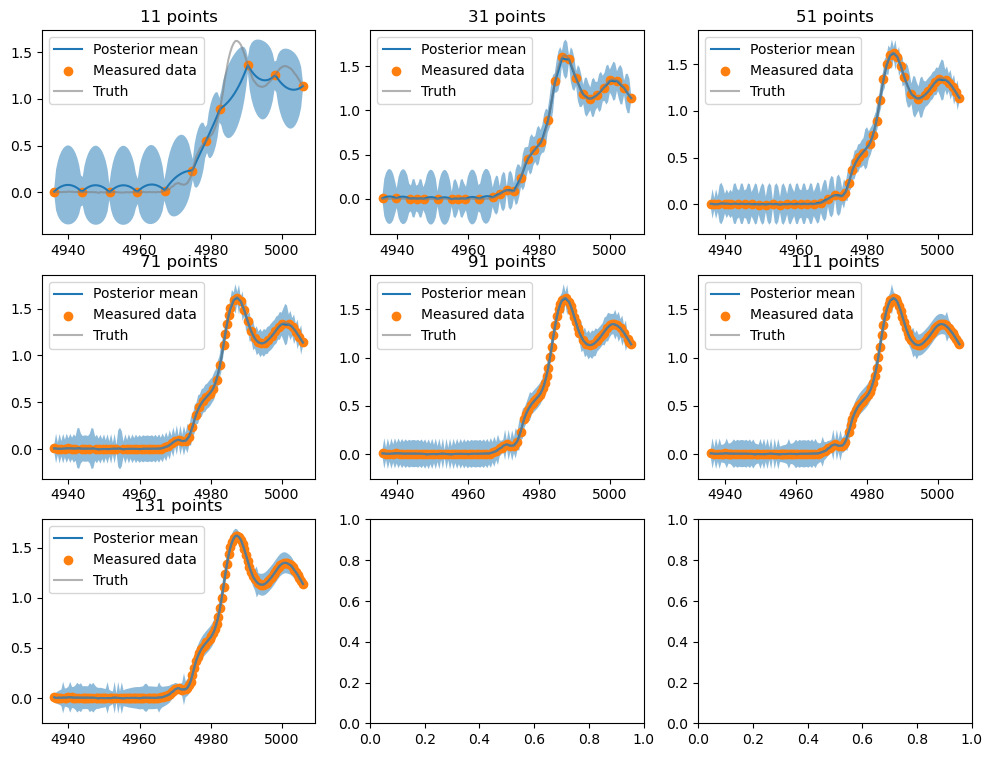

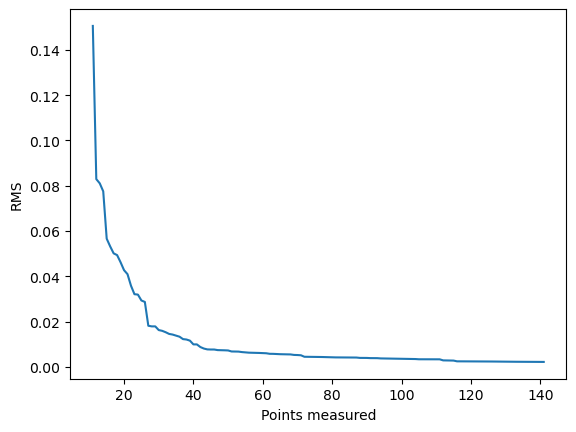

In [14]:
config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(2.5)}
for acquisition_class in [PosteriorStandardDeviation, GradientAwarePosteriorStandardDeviation]:
    if acquisition_class == GradientAwarePosteriorStandardDeviation:
        config.acquisition_function_params = {'phi': 1e-4}
    else:
        config.acquisition_function_params = {}
    for ls in [3.5, 7.0, 14.0]:
        config.acquisition_function_class = acquisition_class
        config.override_kernel_lengthscale = ls
        run_simulated_experiment(config, x_init, y_init)

config.override_kernel_lengthscale = 7.0
for acquisition_class in [PosteriorStandardDeviation, GradientAwarePosteriorStandardDeviation]:
    if acquisition_class == GradientAwarePosteriorStandardDeviation:
        config.acquisition_function_params = {'phi': 1e-4}
    else:
        config.acquisition_function_params = {}
    for nu in [2.5, 1.5, 0.5]:
        config.acquisition_function_class = acquisition_class
        config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(nu)}
        run_simulated_experiment(config, x_init, y_init)

## Combine convergence plots

In [15]:
def combine_convergence_plots(data_dir='outputs'):
    flist = glob.glob(os.path.join(data_dir, '*_conv.txt'))
    fig, ax = plt.subplots(1, 1)
    for fname in flist:
        name = os.path.basename(fname)
        name = name[:name.find('_conv.txt')]
        data = np.loadtxt(fname)
        ax.plot(data[0], data[1], label=name)
    ax.set_xlabel('Points measured')
    ax.set_ylabel('RMS')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    plt.tight_layout()
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False, ncol=1)
    plt.savefig(os.path.join(data_dir, 'combined_conv_plots.pdf'), bbox_inches='tight')

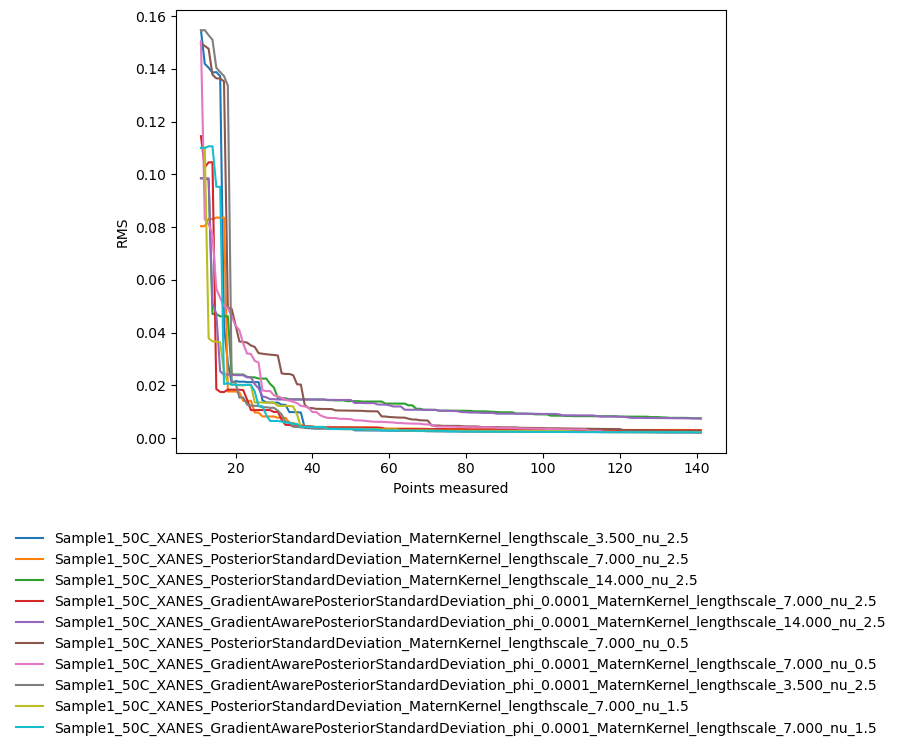

In [16]:
combine_convergence_plots()